# Prueba técnica Científico de datos - Puntored

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
from src.analisis import *
from src.plots import *
from src.outliers import *

## Carga de Datos

In [3]:
file_path = "data/clientes.csv"
raw_data = pd.read_csv(file_path)

- edad (int): Edad del cliente en años.
- ingreso_mensual (float): Ingreso mensual del cliente en una unidad monetaria.
- historial_crediticio (int, 0-5): Evaluación del comportamiento crediticio del cliente, donde 0 indica el peor historial y 5 el mejor.
- default (int, 0 o 1): Indica si el cliente ha incumplido en el pago del crédito (1 = sí, 0 = no).

## Limpieza de datos

### Tipos de Datos

In [4]:
data_types_table(raw_data)

,Data Type
Column Name,
edad,int64
ingreso_mensual,int64
historial_crediticio,int64
default,int64


Todas las columnas almacenan valores numéricos enteros de 64 bits (int64). Este hallazgo es consistente con la descripción de las columnas proporcionada en la documentación de la base de datos.

### Valores Faltantes

In [5]:
missing_values_table(raw_data,True)

Your selected DataFrame has 4 columns and 1000 rows.
There are 0 columns that have missing values.


,Missing Values,% of Total Values
Column Name,,
edad,0,0.0
ingreso_mensual,0,0.0
historial_crediticio,0,0.0
default,0,0.0


Los datos están completos, no se encontraron valores nulos en ninguna de las columnas.

### Análisis Univariado

El análisis univariado, basado en estadísticas descriptivas, histogramas y boxplots, no reveló valores fuera de los rangos esperados en ninguna variable. La distribución de los valores es uniforme en todas las variables, a excepción de `default`, donde se observa un desbalance con una menor cantidad de observaciones en la categoría 1.

#### Estadísticas Descriptivas

In [6]:
describe_dataframe(raw_data, ["edad", "ingreso_mensual", "historial_crediticio"])

,edad,ingreso_mensual,historial_crediticio
statistic,,,
count,1000.000000,1000.000000,1000.000000
mean,44.385000,5966.970000,2.545000
std,15.321669,2306.042730,1.701432
min,18.000000,2002.000000,0.000000
1%,18.000000,2053.990000,0.000000
5%,20.000000,2374.450000,0.000000
25%,31.750000,4034.500000,1.000000
50%,45.000000,5922.000000,3.000000
75%,57.000000,7920.000000,4.000000


#### Histograma

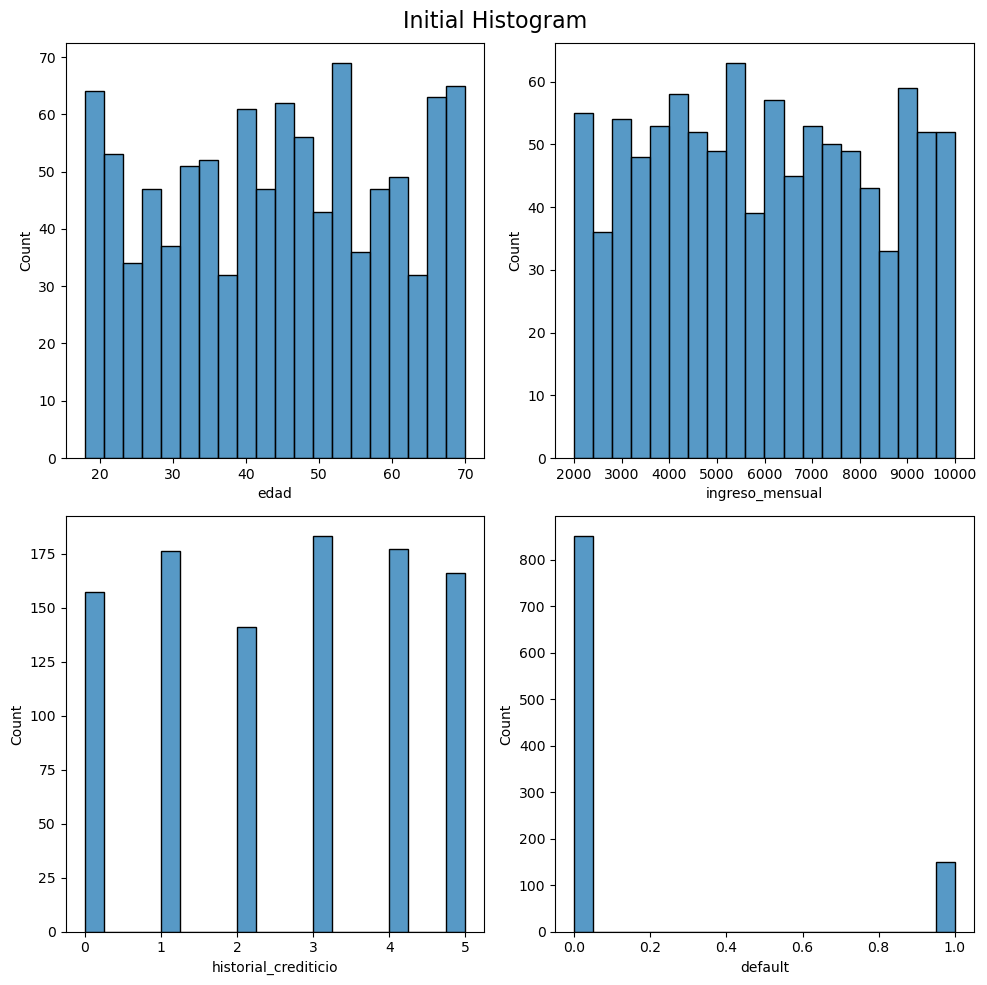

In [7]:
create_subplots(histogram_function, raw_data, list(raw_data.columns), num_rows=2, num_cols=2, title="Initial Histogram", fig_size=(10, 10),share_y=False, bins=20, kde=False)

#### Boxplot

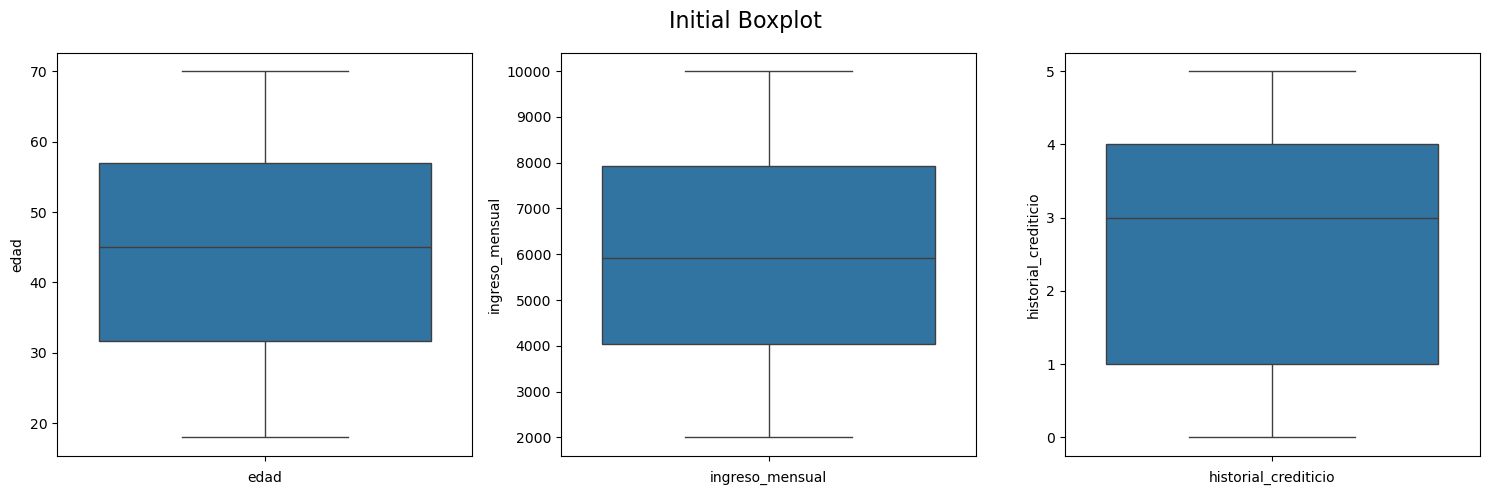

In [8]:
create_subplots(boxplot_function, raw_data, ['edad', 'ingreso_mensual', 'historial_crediticio'], num_rows=1, num_cols=3, title="Initial Boxplot", fig_size=(15, 5))

### Analísis Bivariado

El análisis bivariado utilizando mediante una scatter matrix, no refleja tendencias significativas entre las variables.

### Scatter Matrix

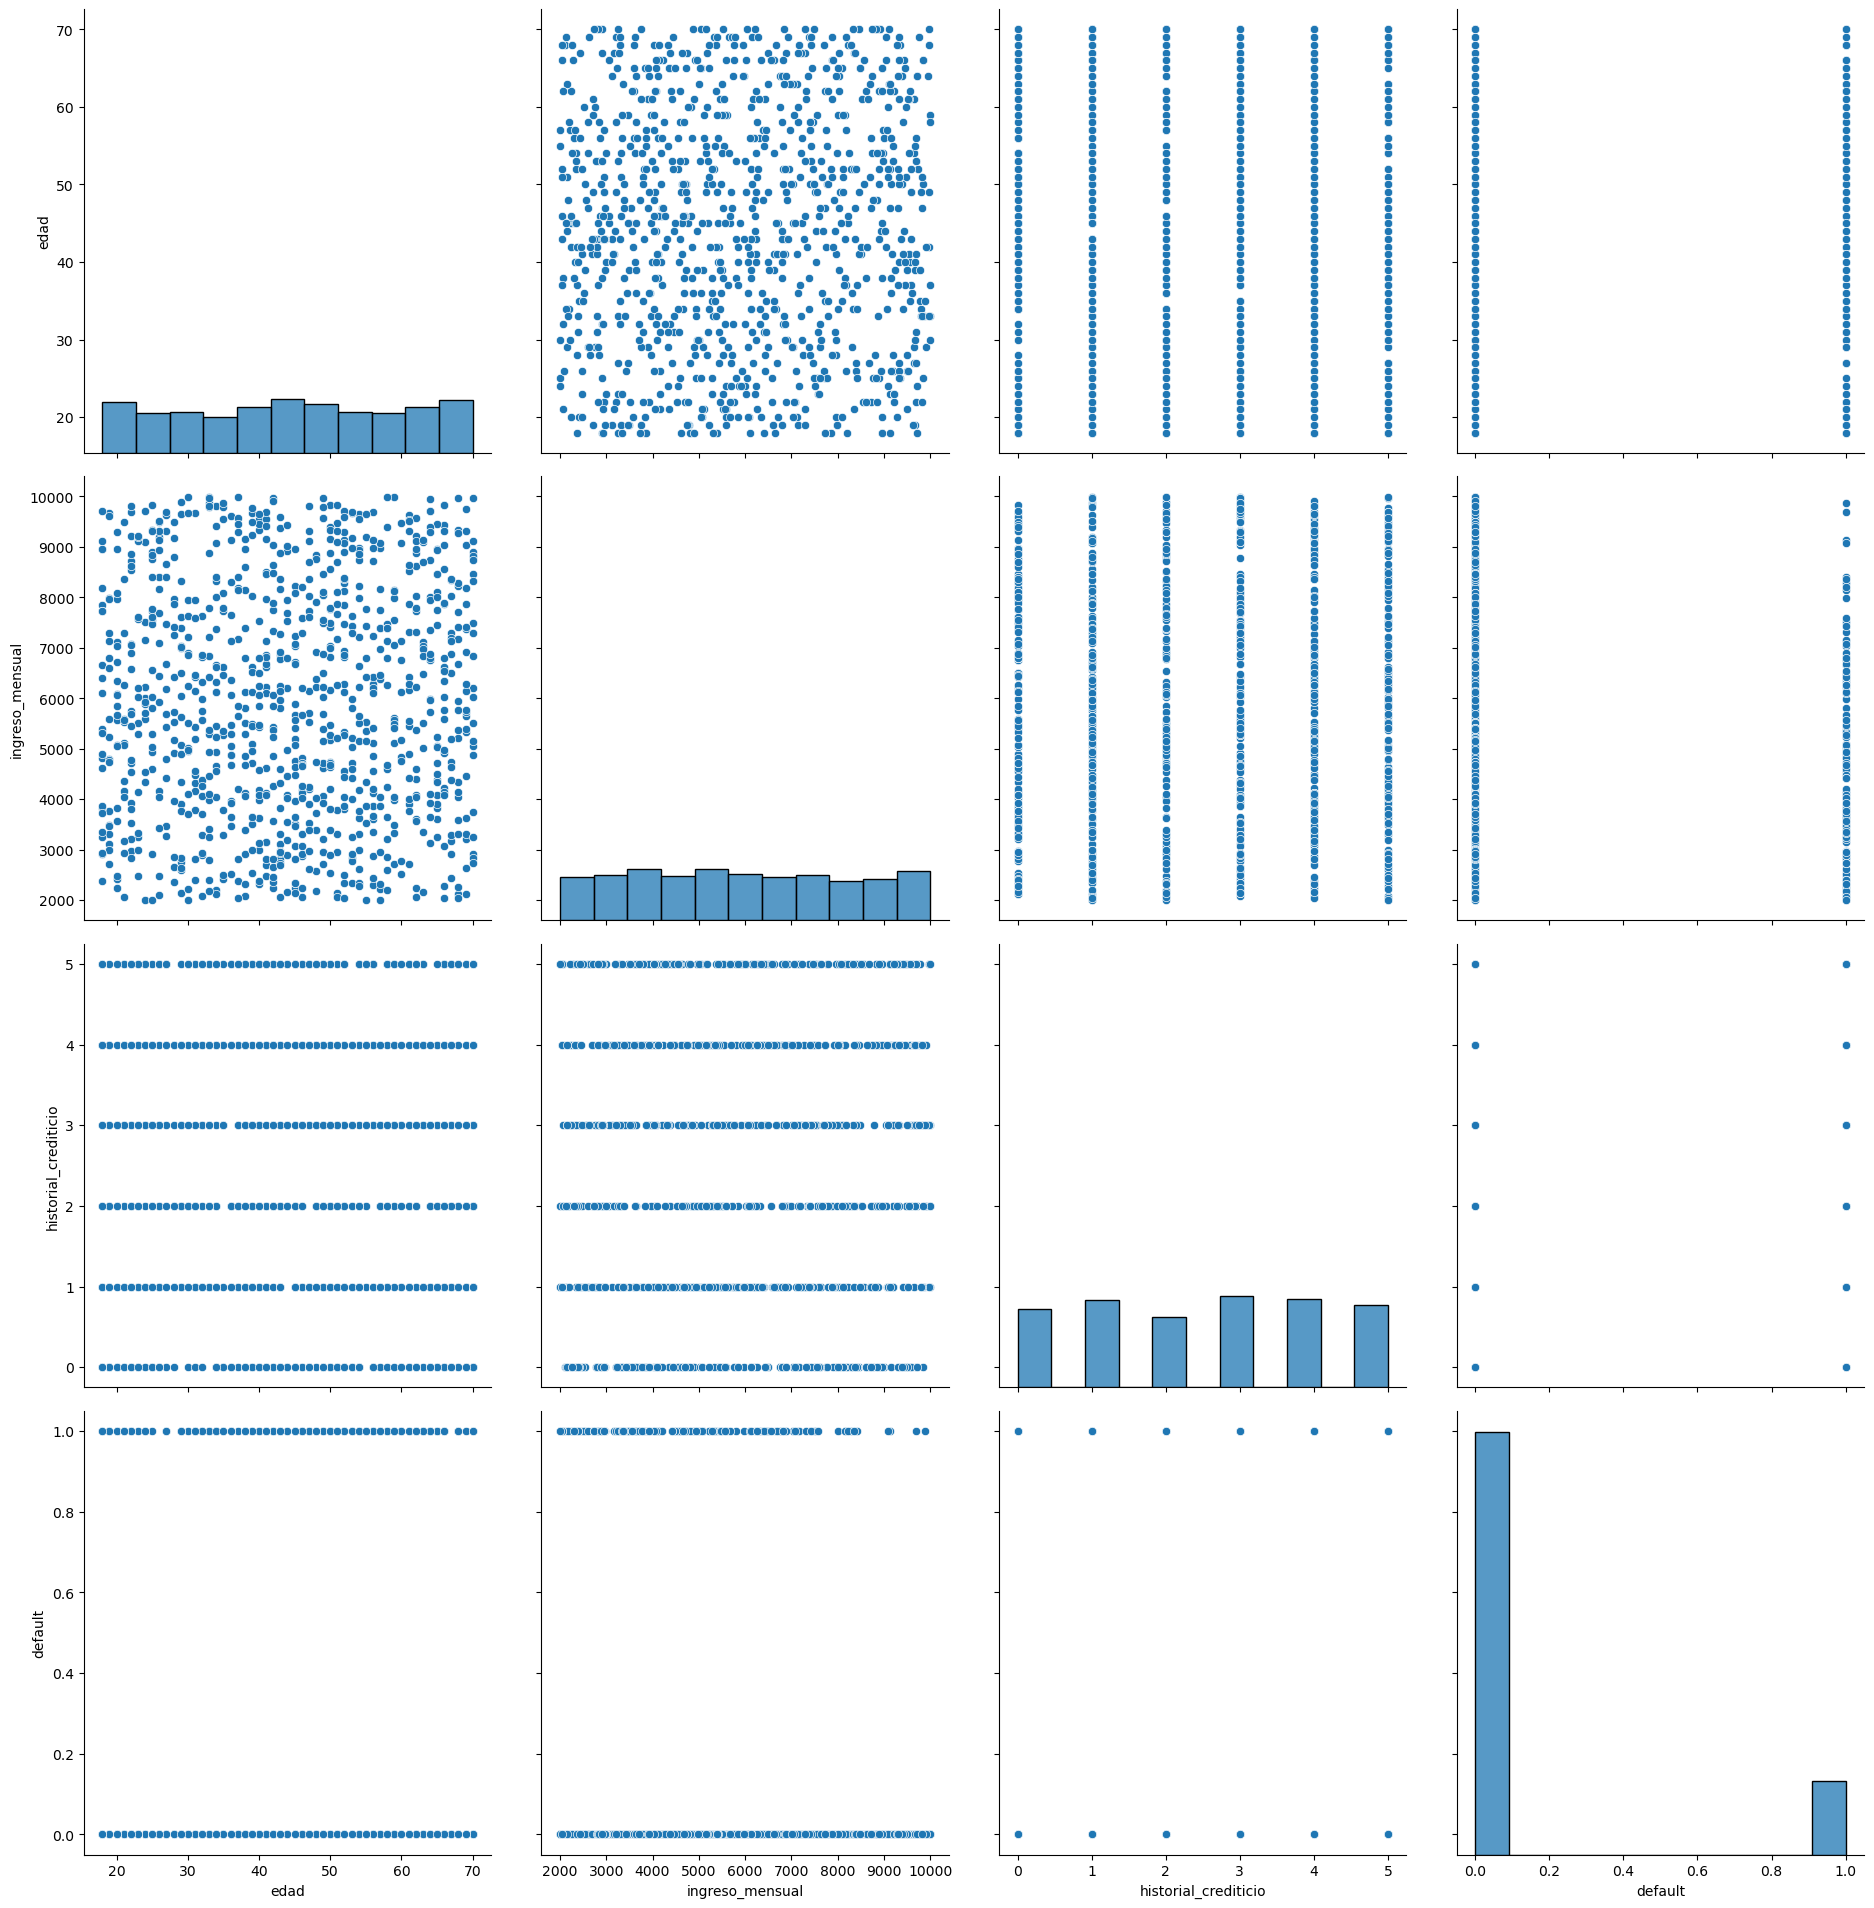

In [9]:
plot_scatter_matrix(raw_data, list(raw_data.columns), fig_size=(20,20))

### Valores Anomalos

A pesar de que el análisis univariado no reveló valores fuera de los rangos esperados, y tanto el análisis univariado como bivariado no mostraron tendencias o patrones claros, se optó por aplicar el algoritmo `Isolation Forest` para explorar posibles anomalías sutiles o multidimensionales que no eran evidentes en análisis más simples y asegurar la calidad de la base de datos. Se descartó el 5% de los datos con mayor probabilidad de ser anómalos, con el objetivo de refinar el conjunto de datos y mejorar la precisión de análisis posteriores.

In [10]:
data, outliers = isolation_forest_clean(raw_data, ["edad", "ingreso_mensual", "historial_crediticio"], 0.05, True)

In [11]:
outliers.sort_values(by=['edad', 'ingreso_mensual', 'historial_crediticio'], ascending=[True, False, True], inplace=True)

### Desbalance en default

La variable objetivo `default` presenta un desbalance significativo, con una mayor cantidad de ejemplos de **0 (clientes que no incumplen el pago)** en comparación con **1 (clientes que sí incumplen)**. Esto puede afectar el desempeño del modelo, ya que podría inclinarse a predecir la clase mayoritaria con alta precisión pero sin capturar correctamente los casos de incumplimiento.

In [12]:
data["default"].value_counts(normalize=True)

default
0    0.852632
1    0.147368
Name: proportion, dtype: float64

## Ingieneria de Caracteristicas

### Matriz de Correlación

Una matriz de correlación es una tabla que muestra la relación entre múltiples variables en un dataset. Cada celda contiene un coeficiente de correlación que indica la fuerza y dirección de la relación entre dos variables, con valores entre -1 (correlación negativa perfecta) y 1 (correlación positiva perfecta). Los valores cercanos a 0 indican que no existe una relación lineal significativa entre las variables. Se usa para detectar patrones y redundancias en los datos.

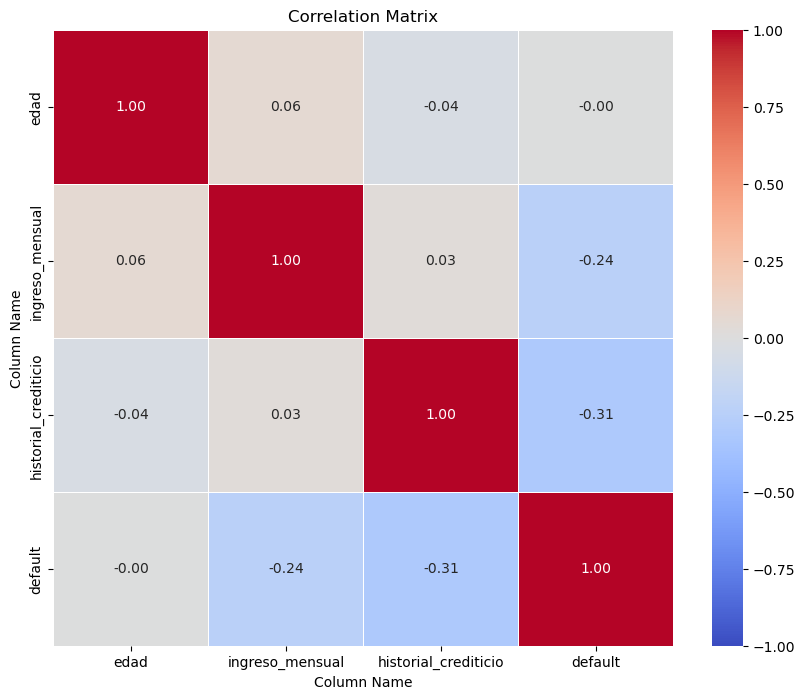

In [13]:
plot_correlation_matrix(data, list(data.columns))

La variable de nuestro interes es `default` y se puede observar que tiene correlaciones negativas con las variables `ingreso_mensual` y `historial_crediticio`. Esto indica que valores bajos de dichas variables estan correlacionados con valores altos de `default`, en otras palabras con un incumpliemnto del pago.

### grupo_edad

La variable `grupo_edad` se creó con el objetivo de capturar patrones financieros y de comportamiento crediticio asociados a diferentes etapas de la vida. Se basa en la edad del cliente y segmenta a la población en cinco grupos clave, reflejando momentos importantes que pueden influir en la estabilidad financiera, el acceso al crédito y la probabilidad de incumplimiento (`default`).

Los grupos definidos son los siguientes:

- 18-25 años: Personas en las primeras etapas de su vida laboral, con menor estabilidad económica y experiencia en el manejo del crédito.
- 26-35 años: Mayor estabilidad laboral, posible adquisición de compromisos financieros como préstamos para educación, automóviles o vivienda.
- 36-45 años: Etapa de consolidación financiera, con mayores ingresos y acumulación de patrimonio.
- 46-60 años: Periodo de estabilidad y planificación para el retiro, con un posible aumento en la capacidad de pago y en la responsabilidad financiera.
- 60+ años: Personas cercanas o en etapa de jubilación, con ingresos potencialmente fijos (pensiones), lo que puede modificar su comportamiento financiero.

Esta segmentación permite evaluar si ciertos rangos de edad están más asociados al incumplimiento crediticio y facilita la interpretación de los resultados del modelo.

In [14]:
bins = [18, 26, 36, 46, 60, 100]
labels = ['18-25', '26-35', '36-45', '46-60', '60+']

In [15]:
data['grupo_edad'] = pd.cut(data['edad'], bins=bins, labels=labels, right=False)
data["grupo_edad"] = data["grupo_edad"].astype(str)

### ingreso_relativo

La variable `ingreso_relativo` se diseñó para medir el nivel de ingresos de cada individuo en relación con la mediana de ingresos de su grupo de edad. Su objetivo es identificar si una persona está ganando más o menos que sus pares en la misma etapa de la vida, lo que puede ser un factor relevante para evaluar su estabilidad financiera y riesgo crediticio.  

Se calcula como:  

$$
\text{ingreso\_relativo} = \frac{\text{ingreso\_mensual\_individuo}}{\text{mediana\_ingreso\_edad}}
$$

Donde:  
- Un valor **mayor que 1** indica que el individuo tiene un ingreso superior a la mediana de su grupo etario.  
- Un valor **menor que 1** indica que el individuo gana menos que la mediana de su grupo etario.  
- Un valor **cercano a 1** sugiere que el ingreso es similar a la mediana del grupo etario.  

Esta variable permite analizar la relación entre ingresos y riesgo de incumplimiento, ayudando a detectar patrones financieros dentro de cada cohorte de edad.


In [16]:
mediana_ingreso_edad = data.groupby("grupo_edad")["ingreso_mensual"].median()

In [17]:
data["ingreso_relativo"] = data["ingreso_mensual"] / data["grupo_edad"].map(mediana_ingreso_edad)

### hist_credit_adj

la variable historial crediticio ajustado `hist_credit_adj` representa el historial crediticio de un individuo ajustado según su grupo etario. Dado que el significado de un buen o mal historial puede variar con la edad, se normaliza restando la media y dividiendo por la desviación estándar del historial crediticio dentro de cada grupo de edad.  

Se calcula como: 
$$
\text{hist\_credit\_adj} = \frac{\text{historial\_crediticio} - \text{media}_{\text{grupo\_edad}}}{\text{desviación}_\text{grupo\_edad}}
$$

Donde: 
- **Valores positivos** Indican un historial crediticio mejor que el promedio de su grupo etareo.  
- **Valores negativos** Indican un historial crediticio peor que el promedio de su grupo etareo.  


In [18]:
media_historial_edad = data.groupby("grupo_edad")["historial_crediticio"].mean()
std_historial_edad = data.groupby("grupo_edad")["historial_crediticio"].std()

In [19]:
data["hist_credit_adj"] = (data["historial_crediticio"] - data["grupo_edad"].map(media_historial_edad)) / data["grupo_edad"].map(std_historial_edad)

### solvencia_financiera

La variable `solvencia_financiera` mide la interacción entre los ingresos de una persona en relación con su grupo etareo y su historial crediticio ajustado. Proporciona una visión combinada de su capacidad de pago y su comportamiento financiero.

Se calcula como:
$$
\text{solvencia\_financiera} = \text{ingreso\_relativo} \times \text{hist\_credit\_adj}
$$

Donde:
- **Valores positivos** Indican una persona con altos ingresos y buen historial crediticio.
- **Valores ligeramente positivos** Indican una persona con bajos ingresos y buen historial crediticio.
- **Valores cercanos a 0** Indican una persona promedio en términos de ingresos e historial crediticio.
- **Valores ligeramente negativos** Indican una persona con bajos ingresos y mal historial crediticio.
- **Valores negativos** Indican una persona con altos ingresos y mal historial crediticio.

In [20]:
data["solvencia_financiera"] = data["ingreso_relativo"] * data["hist_credit_adj"]

### hist_ing_adj

La variable `hist_ing_adj` mide la relación entre el historial crediticio ajustado y el ingreso relativo de una persona. Esta variable ayuda a contextualizar el historial crediticio en función del nivel de ingresos.

Se calcula como: 
$$
\text{hist\_ing\_adj} = \frac{\text{hist\_credit\_adj}}{\text{ingreso\_relativo} + \epsilon}
$$
$\epsilon$ es un valor pequeño para evitar divisiones por cero.

Donde:
- **Valores positivos** Indican una persona con bajos ingresos y buen historial crediticio.
- **Valores ligeramente positivos** Indican una persona con altos ingresos y buen historial crediticio.
- **Valores cercanos a 0** Indican una persona con altos ingresos, independientemente de su historial.
- **Valores ligeramente negativos** Indican una persona con altos ingresos y mal historial crediticio.
- **Valores negativos** Indican una persona con bajos ingresos y mal historial crediticio.


In [21]:
epsilon = 1e-6 
data["hist_ing_adj"] = data["hist_credit_adj"] / (data["ingreso_relativo"] + epsilon)


In [22]:
column_order = ["edad","ingreso_mensual","historial_crediticio", "ingreso_relativo", "hist_credit_adj", "solvencia_financiera","hist_ing_adj", "default"]
data = data[column_order]

### Correlation Matrix - New Variables

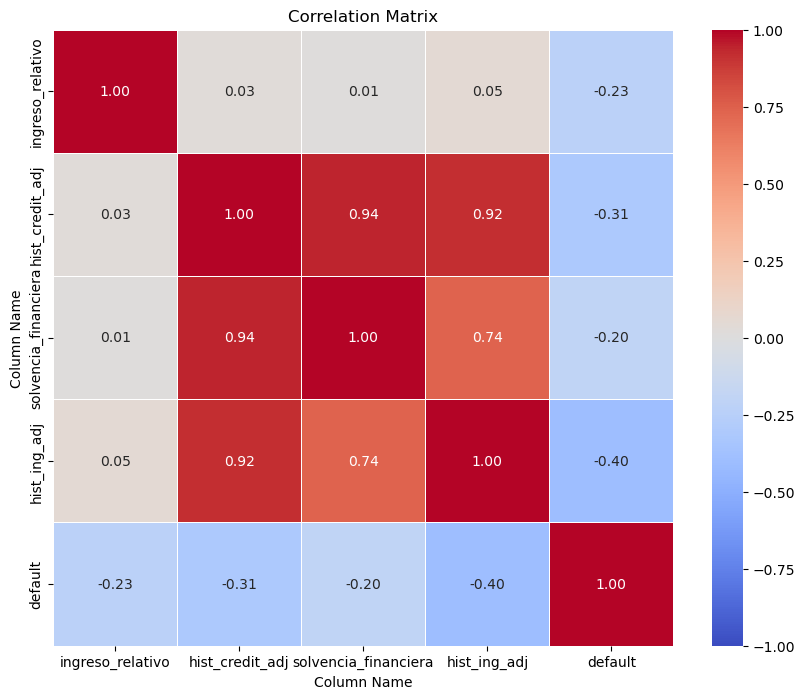

In [23]:
plot_correlation_matrix(data, ["ingreso_relativo", "hist_credit_adj", "solvencia_financiera","hist_ing_adj","default"])

Todas las variables generadas `ingreso_relativo`, `hist_cred_adj`, `solvencia_financiera` y especialmente `hist_ing_adj` tienen correlaciones negativas con nuestra variable de interes `default`. Esto implica que valores bajos de estas variables estan relacionados con el incumplimiento del pago.

## Modelo

Al abordar un problema de clasificación, como la predicción de default en clientes bancarios, es fundamental recordar un principio clave en Machine Learning: **siempre se debe elegir el modelo más sencillo que cumpla adecuadamente con la tarea**. Aunque modelos más complejos, como las redes neuronales, pueden ofrecer un desempeño sobresaliente en ciertos casos, no siempre son la mejor opción. **Modelos más complejos, como redes neuronales, requieren más datos y pueden ser más difíciles de optimizar**, lo que puede hacer que su implementación sea innecesariamente costosa y compleja si un modelo más simple ya logra el desempeño requerido.

En este contexto, he optado por utilizar un `Random Forest` en lugar de una red neuronal por cuatro razones principales:

1. **Eficiencia y suficiencia**: Un `Random Forest` es un modelo robusto, capaz de capturar relaciones no lineales y manejar datos desbalanceados de manera efectiva. En muchos problemas de clasificación estructurados, como este, los modelos basados en árboles ofrecen un rendimiento comparable al de las redes neuronales sin requerir una gran cantidad de hiperparámetros ni un ajuste excesivamente complejo. Si un modelo más simple puede realizar la tarea con un desempeño adecuado, no tiene sentido recurrir a uno más complejo.

2. **Menor necesidad de datos**: Las redes neuronales suelen requerir grandes volúmenes de datos para entrenar modelos precisos y evitar problemas como el sobreajuste. En cambio, los modelos basados en árboles, como `Random Forest`, pueden funcionar bien incluso con conjuntos de datos de tamaño moderado, lo que los hace más adecuados cuando la cantidad de datos disponibles es limitada.

3. **Costo computacional y viabilidad**: A diferencia de las redes neuronales, que pueden requerir hardware especializado y largos tiempos de entrenamiento, un `Random Forest` es más eficiente en términos de recursos computacionales y permite obtener resultados más rápido.

4. **Interpretabilidad**: En este caso particular, no solo nos interesa predecir si un cliente hará **default**, sino también comprender **qué factores contribuyen a esa decisión**. Un `Random Forest` nos permite analizar la importancia de cada variable en la predicción, lo que facilita la identificación de los principales factores de riesgo. Esta información es fundamental para las instituciones financieras, ya que no solo ayuda a desarrollar estrategias proactivas para mitigar el riesgo de incumplimiento, sino que también permite justificar de manera transparente la aprobación o el rechazo de un crédito, evitando problemas legales y éticos.

Si bien tengo experiencia en la implementación de modelos de redes neuronales complejos, en este caso específico un modelo como `Random Forest` ofrece la combinación ideal de **precisión, eficiencia y explicabilidad**. Esto permite no solo tomar decisiones informadas basadas en los datos, sino también entender el **"por qué"** detrás de cada predicción, lo que es fundamental en la gestión del riesgo crediticio.

### Separación de Variables

Por convencion se nombra como `X` a las variables independientes, mientras que la variable dependiente u objetivo se nombra como `y` 

In [24]:
X = data.drop(columns=['default'])
y = data['default']

### Estandarización de Variables

Para facilitar el entrenamiento del modelo se estandarizan las variables independientes lo que ajusta los valores a una distribución con media 0 y desviación estándar 1.

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Validación cruzada K-Fold - División de Datos

La validación cruzada K-Fold se utiliza para evaluar el desempeño de un modelo de Machine Learning de manera más confiable y reducir la varianza asociada a la partición de los datos, asegurando que cada fold tenga aproximadamente la misma proporción de clases.

In [26]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Como vamos a realizar una validación cruzada, no trabajaremos con un único conjunto de entrenamiento y prueba, sino que generaremos cinco particiones distintas de los datos. Debido a esto, no hacemos una división directa, sino que utilizamos `StratifiedKFold`, que nos permite mantener la proporción original de clases en cada subconjunto.

El método `.split()` de `StratifiedKFold` se encarga de que cada observación aparezca una unica vez en el conjunto de prueba y de que la proporción de clases se mantenga constante en todas las divisiones.

Además, usamos `shuffle=True` para mezclar los datos antes de dividirlos, evitando que posibles patrones en el orden original afecten la validación, y `random_state=42` para asegurar reproducibilidad en los resultados.

### Metricas de Evaluación

#### Accuracy (Exactitud)

La **exactitud** mide la proporción de predicciones correctas sobre el total de muestras. Puede ser engañosa en conjuntos de datos desbalanceados como el de este problema, ya que un modelo que siempre predice la clase mayoritaria puede obtener una alta precisión sin ser útil.

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

#### Precisión (Precision)

La **precisión** mide la proporción de predicciones positivas que realmente son positivas. En otras palabras, indica **cuántas de las predicciones positivas son correctas**.

$$
Precision = \frac{TP}{TP + FP}
$$

#### Recall (Sensibilidad)

El **recall** mide la proporción de casos positivos que el modelo identificó correctamente. Es decir, **qué tan bien encuentra todos los casos positivos reales**. Tambien es conocida como Tasa de Verdaderos Positivos (True Positive Rate - TPR).

$$
Recall = \frac{TP}{TP + FN}
$$

#### Tasa de Falsos Positivos (False Positive Rate - FPR)

La **Tasa de Falsos Positivos** mide la proporción de **casos negativos** que fueron **incorrectamente clasificados como positivos**. Es un indicador de cuántos falsos positivos genera un modelo en comparación con todos los casos negativos reales.

$$
FPR = \frac{FP}{FP + TN}
$$

#### F1-Score

El **F1-Score** es la media armónica entre la precisión (**Precision**) y la sensibilidad (**Recall**), útil cuando hay clases desbalanceadas.


$$
F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

#### AUC-ROC (Area Under Curve - Receiver Operating Characteristic)

El **AUC-ROC** mide la capacidad del modelo para distinguir entre las clases en distintos umbrales de decisión.

- La **Curva ROC** grafica la tasa de verdaderos positivos (**TPR**) contra la tasa de falsos positivos (**FPR**) para distintos umbrales de decisión. 

- El **AUC (Área Bajo la Curva)** representa la capacidad discriminativa del modelo:
  - **AUC = 1.0** → Clasificación perfecta.
  - **AUC = 0.5** → Modelo sin capacidad predictiva (aleatorio).
  - **AUC < 0.5** → Peor que aleatorio.

#### Selección de Metrica

Aunque `Accuracy` es una de las métricas más utilizadas en problemas de clasificación, su fiabilidad depende de que las clases estén balanceadas. En nuestro caso, donde aproximadamente el 85% de los datos pertenecen a la clase 0 (no default), el modelo podría simplemente predecir siempre esta clase y aún así obtener un 85% de accuracy, sin realmente aportar valor en la identificación de clientes en riesgo de default.

Por otro lado, el `F1-Score` es útil en escenarios con clases desbalanceadas cuando el costo de los falsos positivos y falsos negativos es similar. Sin embargo, esta métrica se calcula para un umbral de decisión fijo, lo que limita nuestra capacidad de ajustar el modelo según nuestras prioridades. En este caso, nuestro principal objetivo es identificar a la mayor cantidad posible de clientes que harán default, incluso si eso implica ajustar el umbral de decisión para hacer el modelo más sensible a esta clase.

Dado este contexto, la métrica más adecuada es el `AUC-ROC`, ya que evalúa la capacidad del modelo para distinguir entre ambas clases en todos los posibles umbrales de decisión, sin depender de una única configuración. Además, no se ve afectada por el desbalance de clases, lo que la convierte en una mejor opción para evaluar el desempeño real del modelo en este problema.

### Entrenamiento y Evaluación

Para cada una de las 5 divisiones del conjunto de datos:
1. Se dividen los datos en entrenamiento y prueba.
2. Se entrena un modelo de `Random Forest`.
3. Se generan predicciones sobre el conjunto de prueba.
4. Se calculan las métricas de evaluación - `AUC-ROC`.
5. Se almacena el modelo y la división de sus datos.

In [27]:
f1_scores, acc_scores, auc_scores = [], [], []
k_folds = []

for train_index, test_index in kf.split(X_scaled, y):
    # División de los datos
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight="balanced",
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    f1_scores.append(f1_score(y_test, y_pred))
    acc_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    k_folds.append((model, X_train, X_test, y_train, y_test))


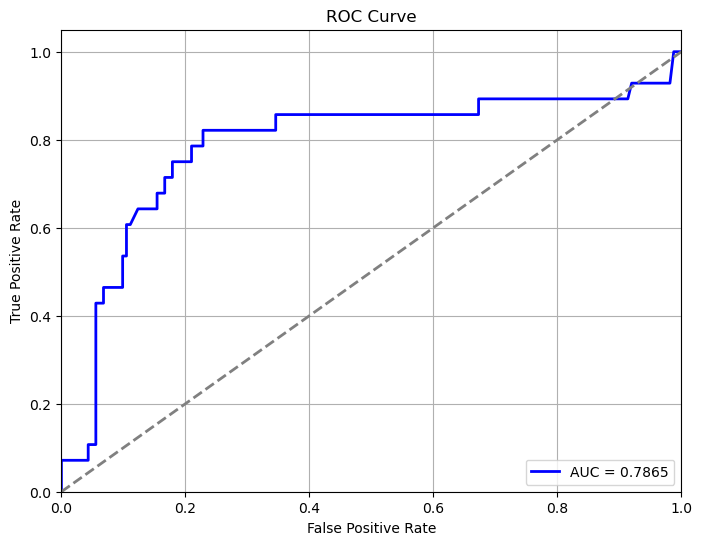

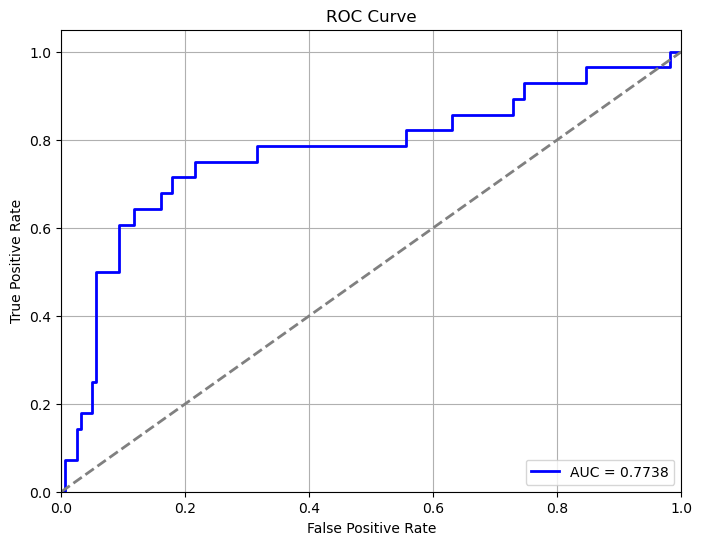

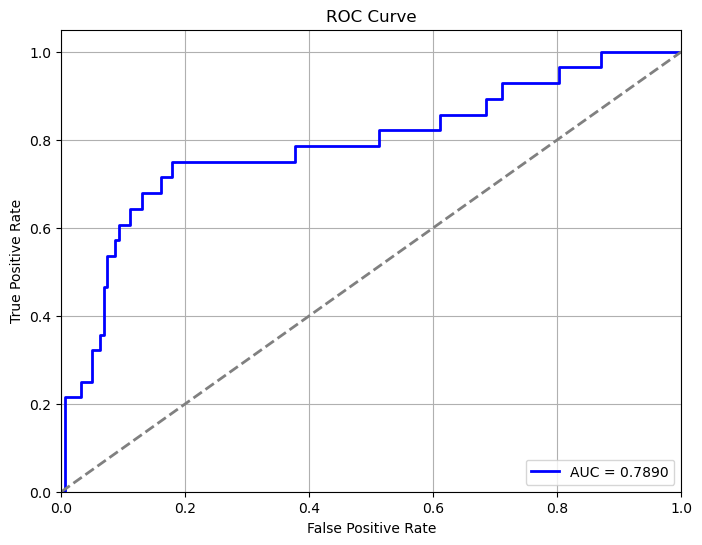

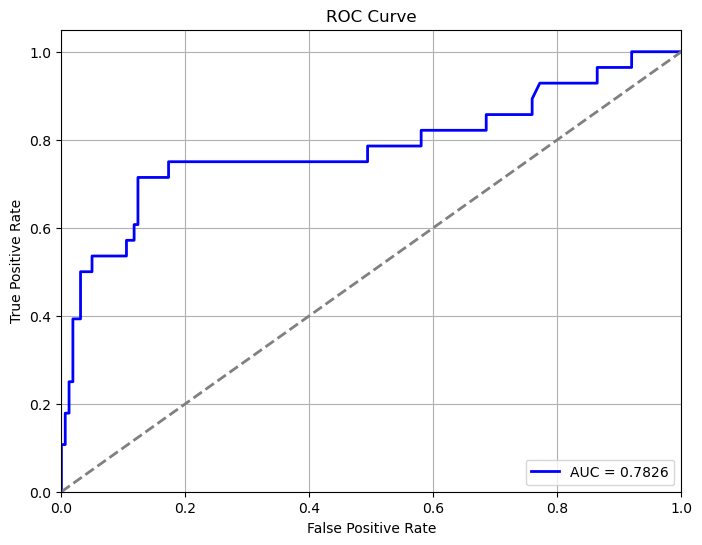

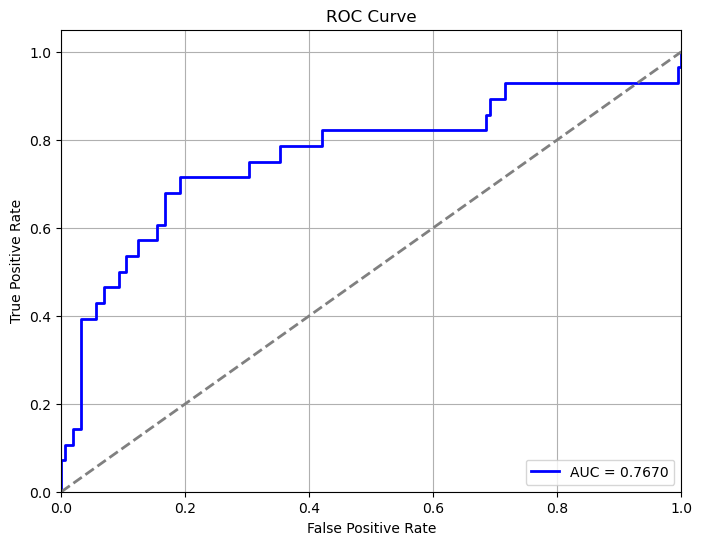

In [28]:
for i in k_folds:
    model, X_train, X_test, y_train, y_test = i
    plot_auc_roc(model, X_test, y_test)

In [29]:
print(f"AUC Scores: {[f"{score:.4f}" for score in auc_scores]}")
print(f"AUC-ROC Promedio: {np.mean(auc_scores):.4f}")

AUC Scores: ['0.7865', '0.7738', '0.7890', '0.7826', '0.7670']
AUC-ROC Promedio: 0.7798


En este caso, un AUC-ROC de 0.7798 significa que, en promedio, el modelo tiene un 77.98% de probabilidad de asignar un mayor puntaje de riesgo a un cliente que efectivamente hará default, en comparación con uno que no lo hará. Dicho de otra manera, si seleccionamos aleatoriamente un cliente que incumplirá su crédito y otro que no, el modelo otorgará un mayor puntaje de riesgo al primero en el 77.98% de los casos.

Los valores de AUC-ROC varían entre 0.76 y 0.78 a lo largo de los diferentes folds, con un promedio de 0.7798. Esto implica que, si entrenamos un modelo final con todos los datos disponibles y realizamos predicciones sobre datos completamente nuevos, el desempeño podría oscilar dentro de este rango. Es decir, dependiendo de la composición de los datos de prueba, el AUC-ROC podría ser tan bajo como 0.76 o tan alto como 0.78, pero con una expectativa central en 0.7798. Esto implica un modelo poco volatil.

Para mejorar su generalización, se recomienda la recolección de más datos para mejorar la representatividad del conjunto de entrenamiento.

### Interpretabilidad

La interpretabilidad de un modelo se refiere a la capacidad de comprender cómo y por qué toma sus decisiones. Un modelo interpretable permite explicar su funcionamiento, identificar las variables más influyentes y generar confianza en sus predicciones, facilitando su uso en contextos donde la transparencia es crucial.

In [30]:
model, X_train, X_test, y_train, y_test = k_folds[0] # Extraemos un modelo para su interpretacion

#### Importancia de las Características

En un `Random Forest`, la importancia de características mide cuánto contribuye cada variable a la capacidad predictiva del modelo.

¿Cómo se interpreta?

- Valores altos indican que una característica es relevante para la predicción.

- Valores bajos o cercanos a cero sugieren que la variable tiene poca o ninguna influencia en el modelo.

En la práctica, la importancia de características se usa para:

1. Identificar las variables más relevantes y descartar aquellas con menor impacto.

2. Comprender mejor el comportamiento del modelo, especialmente en problemas donde la interpretabilidad es clave.

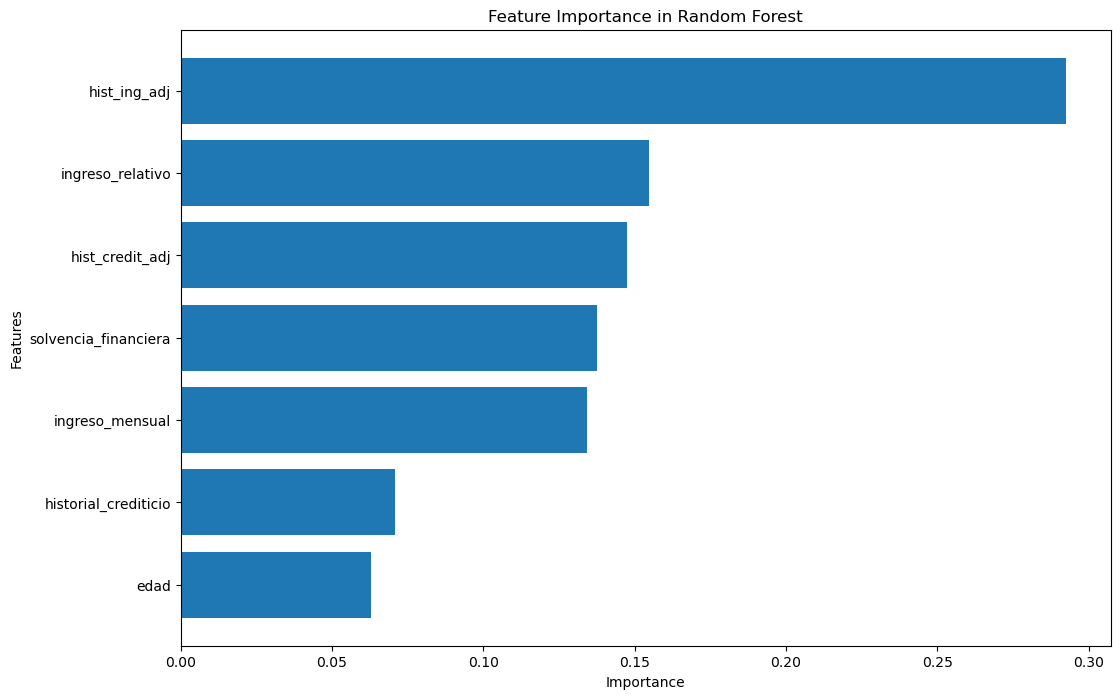

In [31]:
plot_feature_importance(model, X.columns, figsize=(12, 8))

Las variables generadas mediante ingeniería de características presentan las mayores importancias dentro del modelo, destacando especialmente `hist_ing_adj` como la más relevante. En contraste, las variables originales, como `edad`, `historial_crediticio` e `ingreso_mensual`, muestran una menor contribución, siendo `historial_crediticio` y `edad` las de menor impacto en la clasificación.

Esto sugiere que la información contenida en estas variables originales podría estar representada en otras características más relevantes. Por lo tanto, podrían ser descartadas en futuras optimizaciones del modelo para reducir la dimensionalidad sin afectar significativamente el desempeño predictivo.